<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Project Outline

- Public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.
- The dataset is broken into 1490 records for training and 735 for testing. The train dataset is split up into 3 columns: ArticleId, Category, and text.
- The goal will be to build a system that can accurately classify previously unseen news articles into the right category. I aim to do this using Non-Negative Matrix Factorization. I will then classify the data into five different categories to help measure the accuracy.
- Lastly I will do a comparison against supervised learning techniques like Logistic Regression and Random forest to see the differences in the accuracy.
- The competition is evaluated using Accuracy as a metric.

</div>

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from joblib import Parallel, delayed
from itertools import permutations

In [26]:
# Loads the kaggle data sets from the sample data set folder
trainDataSet = pd.read_csv("./sampleData/BBC News Train.csv")
testDataSet = pd.read_csv("./sampleData/BBC News Test.csv")
solutionDataSet = pd.read_csv("./sampleData/BBC News Sample Solution.csv")

In [27]:
# Creates a dictionary of the different categories I will be investigating.
categoryDict = {
  'business': 0,
  'entertainment': 1,
  'politics': 2,
  'sport': 3,
  'tech': 4
}
trainDataSet['CategoryId'] = trainDataSet.Category.map(categoryDict)
trainDataSet

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in $168m payout eighteen former e...,business,0
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,4


In [28]:
# Joins together the test data set and the category column from the solution dataset. 
finalDataSet = pd.concat([testDataSet, solutionDataSet['Category']], axis = 1)

# Joins together the final dataset I just created with the 3 columns inside of the train dataset.
finalDataSet = pd.concat([finalDataSet, trainDataSet[['ArticleId', 'Text', 'Category']]], axis = 0)
finalDataSet['CategoryId'] = finalDataSet['Category'].map(categoryDict)
finalDataSet

,ArticleId,Text,Category,CategoryId
0,1018,qpr keeper day heads for preston queens park r...,sport,3
1,1319,software watching while you work software that...,tech,4
2,1138,d arcy injury adds to ireland woe gordon d arc...,business,0
3,459,india s reliance family feud heats up the ongo...,entertainment,1
4,1020,boro suffer morrison injury blow middlesbrough...,politics,2
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1
1487,1590,weak dollar hits reuters revenues at media gro...,business,0
1488,1587,apple ipod family expands market apple has exp...,tech,4


<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Explorative Data Analysis (EDA)

</div>

## Train Data EDA
- Inspecting the train dataset to learn more about it.
- Reviews the top 20 words inside of each of my selected categories.
- Views how the words are distrubted across the data.

In [29]:
print(trainDataSet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   1490 non-null   int64 
 1   Text        1490 non-null   object
 2   Category    1490 non-null   object
 3   CategoryId  1490 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.7+ KB
None


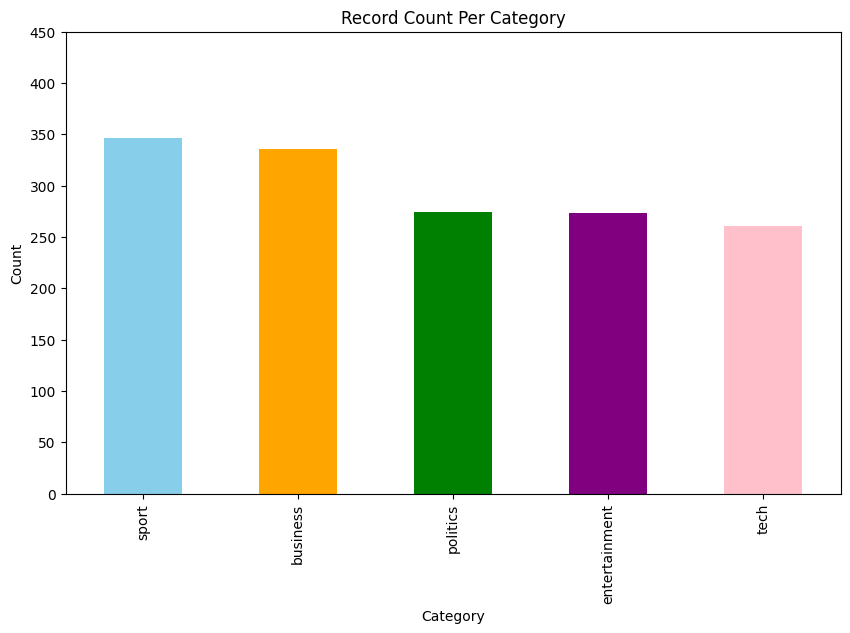

In [30]:
# Plots the data of the count of words related to each category in the train data set.
categoryCounts = trainDataSet['Category'].value_counts()
plt.figure(figsize=(10, 6))
categoryCounts.plot(kind = 'bar', color = ['skyblue', 'orange', 'green', 'purple', 'pink'])
plt.title("Record Count Per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.ylim(0, 450)
plt.show()

In [31]:
# Generates a dictionary containing the individual words from the text column and the number of times those words have been seen.
def generateWordCountDict(words):    
    # Removes all punctuation from the text column from the csv
    removedPunctuationPhrase = []
    for word in words:
        for punctuation in string.punctuation:
            if punctuation in word:
                word = word.replace(punctuation, '')
        removedPunctuationPhrase.append(word)
    
    # Cuts the phrase up into individual words instead of a long string
    individualWordsWithoutPunctuation = []
    for word in removedPunctuationPhrase:
        individualWordsWithoutPunctuation += word.split(" ")
    
    # Eliminates all of the ENGLISH_STOP_WORDS and gets rid of any empty strings
    wordsWithRemovedStopWordsAndEmptyStrings = [word for word in individualWordsWithoutPunctuation if word.lower() not in ENGLISH_STOP_WORDS and word != '']
    
    # Create a dict with words and number of occurrences
    wordCounterDict = {}
    for word in wordsWithRemovedStopWordsAndEmptyStrings:
        if word not in wordCounterDict:
            wordCounterDict[word] = 1
        else:
            wordCounterDict[word] += 1
    return wordCounterDict

# Creates boolean masks for each category.
businessMask = trainDataSet['Category'] == 'business'
entertainmentMask = trainDataSet['Category'] == 'entertainment'
politicsMask = trainDataSet['Category'] == 'politics'
sportMask = trainDataSet['Category'] == 'sport'
techMask = trainDataSet['Category'] == 'tech'

elementsWithMasks  = [ trainDataSet['Text'][businessMask], trainDataSet['Text'][entertainmentMask], trainDataSet['Text'][politicsMask], trainDataSet['Text'][sportMask], trainDataSet['Text'][techMask]  ]
generatedWordCountDict = [generateWordCountDict(element) for element in elementsWithMasks]

In [32]:
# Contructs the final sorted tuple with the unique words and the removed words. 
def constructSortedTuple(category_dict, excluded_dicts):
    notIncludedWords = set(word for d in excluded_dicts for word in d.keys())
    uniqueWords = {key: value for key, value in category_dict.items() if key not in notIncludedWords}
    uniqueWordsSorted = sorted(uniqueWords.items(), key=lambda x: x[1], reverse=True)
    return uniqueWordsSorted

# Lists out dicts that are not to be included for the given category id
def generateNotIncludedCategoryDict(category_index, all_dicts):
    """Returns a list of dictionaries to be excluded for a given category index"""
    return [dicts for i, dicts in enumerate(all_dicts) if i != category_index]

# Returns a tuple with a word and the number of that word seen under that specific category id
def generateUniqueWordCountTuple(list_of_dicts):
    """Returns a tuple with word and count for unique words within each text category"""
    unique_words_list = []
    
    for i, category_dict in enumerate(list_of_dicts):
        excluded_dicts = generateNotIncludedCategoryDict(i, list_of_dicts)
        unique_words_list.append(constructSortedTuple(category_dict, excluded_dicts))
    
    return tuple(unique_words_list)

uniqueBusinessWords, uniqueEntertainmentWords, uniquePoliticsWords, uniqueSportWords, uniqueTechWords = generateUniqueWordCountTuple(generatedWordCountDict)

# Passes a list of the top 20 occurences of words relating to each category.
categoryTop20 = { 'business': uniqueBusinessWords[:20],
        'entertainment': uniqueEntertainmentWords[:20],
        'politics': uniquePoliticsWords[:20], 
        'sport': uniqueSportWords[:20],
        'tech': uniqueTechWords[:20] 
}

trainDataSet_unique = pd.DataFrame(categoryTop20)
trainDataSet_unique

,business,entertainment,politics,sport,tech
0,"(yukos, 120)","(actress, 116)","(tory, 167)","(roddick, 97)","(mobiles, 94)"
1,"(worldcom, 54)","(festival, 100)","(tories, 158)","(referee, 66)","(gadgets, 88)"
2,"(gm, 54)","(oscar, 87)","(lib, 133)","(athens, 64)","(spam, 80)"
3,"(lse, 51)","(aviator, 76)","(ukip, 101)","(nadal, 59)","(portable, 74)"
4,"(imf, 50)","(oscars, 55)","(asylum, 78)","(slam, 58)","(viruses, 57)"
5,"(ebbers, 45)","(foxx, 48)","(dems, 77)","(mourinho, 58)","(highdefinition, 54)"
6,"(creditors, 40)","(sideways, 40)","(lords, 74)","(wenger, 54)","(blog, 48)"
7,"(gazprom, 40)","(drake, 39)","(kilroysilk, 74)","(championships, 54)","(p2p, 44)"
8,"(fiat, 40)","(elvis, 38)","(blunkett, 49)","(gara, 48)","(multimedia, 42)"
9,"(securities, 38)","(actors, 37)","(goldsmith, 35)","(athletics, 46)","(wifi, 42)"


## Complete Data EDA
- Inspecting the train dataset to learn more about it.
- Reviews the top 20 words inside of each of my selected categories.
- Views how the words are distrubted across the data.

In [33]:
print(trainDataSet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   1490 non-null   int64 
 1   Text        1490 non-null   object
 2   Category    1490 non-null   object
 3   CategoryId  1490 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.7+ KB
None


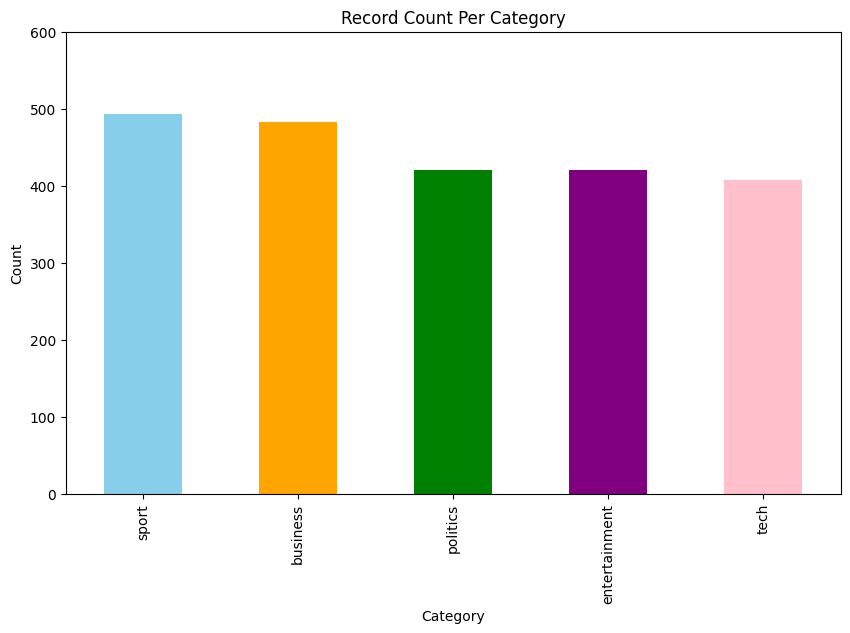

In [34]:
# Plots the data of the count of words related to each category in the final data set.
categoryCounts = finalDataSet['Category'].value_counts()

plt.figure(figsize=(10, 6))
categoryCounts.plot(kind = 'bar', color = ['skyblue', 'orange', 'green', 'purple', 'pink'])
plt.title("Record Count Per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.ylim(0, 600)
plt.show()

In [35]:
# Creates boolean masks for each category.
businessMask = finalDataSet['Category'] == 'business'
entertainmentMask = finalDataSet['Category'] == 'entertainment'
politicsMask = finalDataSet['Category'] == 'politics'
sportMask = finalDataSet['Category'] == 'sport'
techMask = finalDataSet['Category'] == 'tech'
elementsWithMasks = [ finalDataSet['Text'][businessMask], finalDataSet['Text'][entertainmentMask], finalDataSet['Text'][politicsMask], finalDataSet['Text'][sportMask], finalDataSet['Text'][techMask]  ]

# Creates a dict containing all of the words sorted into their categories.
generatedWordCountDict = [generateWordCountDict(element) for element in elementsWithMasks]
uniqueBusinessWords, uniqueTechWords, uniquePoliticsWords, uniqueSportWords, uniqueEntertainmentWords = generateUniqueWordCountTuple(generatedWordCountDict)

# Passes a list of the top 20 occurences of words relating to each category.
categoryTop20 = { 
    'business': uniqueBusinessWords[:20], 
    'entertainment': uniqueEntertainmentWords[:20], 
    'politics': uniquePoliticsWords[:20], 
    'sport': uniqueSportWords[:20], 
    'tech': uniqueTechWords[:20] 
}

finalDataSet_unique = pd.DataFrame(categoryTop20)
finalDataSet_unique

,business,entertainment,politics,sport,tech
0,"(wto, 27)","(p2p, 45)","(hunts, 24)","(gallas, 26)","(depp, 18)"
1,"(cairn, 25)","(hd, 33)","(mock, 17)","(corry, 24)","(pops, 17)"
2,"(verizon, 22)","(firefox, 30)","(galloway, 16)","(kuznetsova, 23)","(brando, 17)"
3,"(wmc, 20)","(hdtv, 29)","(tb, 16)","(drogba, 22)","(viotti, 16)"
4,"(fannie, 19)","(iptv, 24)","(baa, 14)","(lampard, 20)","(fightstar, 15)"
5,"(qwest, 19)","(uwb, 24)","(espn, 13)","(aragones, 20)","(kasabian, 13)"
6,"(mae, 18)","(rfid, 23)","(csos, 13)","(neville, 19)","(reggae, 13)"
7,"(chartered, 18)","(explorer, 21)","(hutt, 12)","(harriers, 18)","(neeson, 13)"
8,"(reddy, 17)","(millan, 20)","(hansard, 12)","(clijsters, 17)","(busted, 13)"
9,"(coal, 16)","(argonaut, 19)","(everquest, 11)","(northampton, 16)","(fenice, 12)"


## Summary
- Data between the categories is evenly dispersed across the different categories. This can be seen for both the train and final datasets.
- The Sport and Business categories tend to to have slightly higher word counts across both different datasets.
- It is easier to distinguish data inside of the train data set when looking at the data, but when looking at the final dataset, the data becomes harder to distinguish when looking at the final dataset since the words tend to relate to more than just one category.

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Model Construction / Testing
- Firstly, I aim to clean the data using several different techniques. I will remove all of the english stop words and any empty strings.
- I will create a TfidfVectorizer class to help vectorize the documents and only include the words that appear within a certain margin of inclusion.
- Next, I will build a Non-Negative Matrix Factorization model and use that to select the top 20 words from each selected category. The model will then predict the categories and produce an accuracy and confusion matrix.
- Lastly I will apply regularization techniques to my model to limit the number of words that can be used. This will be used for both train and final data sets to determine the overall best accuracy.
</div>

## Train Data Construction

In [36]:
# Created a TF-IDF matrix from the text column
tfidfMatrix = TfidfVectorizer(max_df=.95, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
trainFeatures = tfidfMatrix.fit_transform(trainDataSet['Text'])

# Creates a NMF model with 5 compoents  and fits that model to the TF-IDF matrix above
nmfModel = NMF(n_components = 5, init='random', random_state = 123)
nmfModel.fit(trainFeatures)

print(f"Model Information: {nmfModel}\n")
for index, topic in enumerate(nmfModel.components_):
    print(f"Top words for topic: {index}")
    print(f"Array of words: {[tfidfMatrix.get_feature_names_out()[i] for i in topic.argsort()[-20:]]}\n")

Model Information: NMF(init='random', n_components=5, random_state=123)

Top words for topic: 0
Array of words: ['lib', 'campaign', 'tories', 'tory', 'chancellor', 'tax', 'howard', 'prime minister', 'prime', 'minister', 'government', 'mr brown', 'mr blair', 'said', 'party', 'brown', 'blair', 'election', 'labour', 'mr']

Top words for topic: 1
Array of words: ['injury', 'coach', 'world', 'final', 'season', 'time', 'half', 'france', 'match', 'chelsea', 'players', 'play', 'team', 'ireland', 'said', 'cup', 'wales', 'win', 'game', 'england']

Top words for topic: 2
Array of words: ['profits', 'government', 'india', 'rates', 'prices', 'company', 'dollar', 'firm', 'shares', 'china', '2004', 'economic', 'oil', 'bank', 'market', 'sales', 'year', 'economy', 'growth', 'said']

Top words for topic: 3
Array of words: ['search', 'new', 'online', 'video', 'tv', 'service', 'use', 'broadband', 'microsoft', 'net', 'software', 'phones', 'users', 'digital', 'technology', 'phone', 'said', 'music', 'people'

In [37]:
# Generates a list of dicts for finding the best match
def generatePermutationList():
    listOfPermutations = permutations([0, 1, 2, 3, 4])
    return [{0: perm[0], 1: perm[1], 2: perm[2], 3: perm[3], 4: perm[4]} for perm in listOfPermutations]

# Generates best accuracy for a given transformer
def computeAccuracy(transformer, true_labels, topicResults):
    return accuracy_score(true_labels, topicResults.map(transformer))

topicResults = nmfModel.transform(trainFeatures).argmax(axis = 1)
labels = trainDataSet['CategoryId']
topicResults = pd.Series(topicResults)

# Parallelize the loop using joblib
results = Parallel(n_jobs=-1)(
    delayed(computeAccuracy)(transformer, labels, topicResults)
    for transformer in generatePermutationList()
)

# Find the best result
bestIndex = np.argmax(results)
best_transformer = generatePermutationList()[bestIndex]
bestAccuracy = results[bestIndex]

print("Best Accuracy Score:", bestAccuracy)

Best Accuracy Score: 0.9033557046979865


[Text(0, 0.5, 'business'),
 Text(0, 1.5, 'entertainment'),
 Text(0, 2.5, 'politics'),
 Text(0, 3.5, 'sport'),
 Text(0, 4.5, 'tech')]

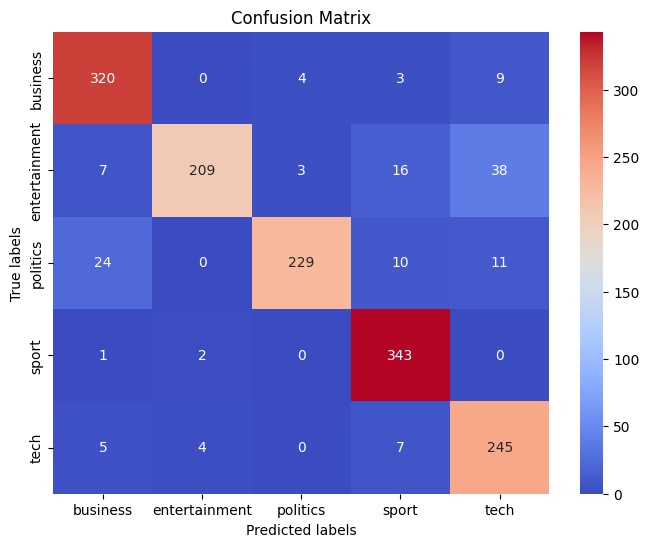

In [38]:
mappedLabels = topicResults.map(best_transformer)
confusionMatrix = confusion_matrix(trainDataSet['CategoryId'], mappedLabels)

fig, subPlot = plt.subplots(figsize = (8, 6))
sns.heatmap(confusionMatrix, annot = True, fmt = 'g', ax = subPlot, cmap = 'coolwarm')

subPlot.set_xlabel('Predicted labels')
subPlot.set_ylabel('True labels')
subPlot.set_title('Confusion Matrix')
subPlot.xaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech' ])
subPlot.yaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech' ])

## Regularization and Model Construction
- Here I start by generated my Non-Negative Matrix Factorization model and fitting it.
- I calculate the accuracy score for a given regularizer value using a Non-Negative Matrix Factorization (NMF) model. The NMF model is fitted on a subset of trainFeatures starting from the specified regularizer index.
- The topic results are obtained by transforming the subset of trainFeatures and finding the index of the maximum value for each data point.
- The final accuracy score returned by the function is the maximum among the calculated accuracy scores.
- Then I go on to plotting the data and viewing the frequency of each word compared to the predicted accuracy.

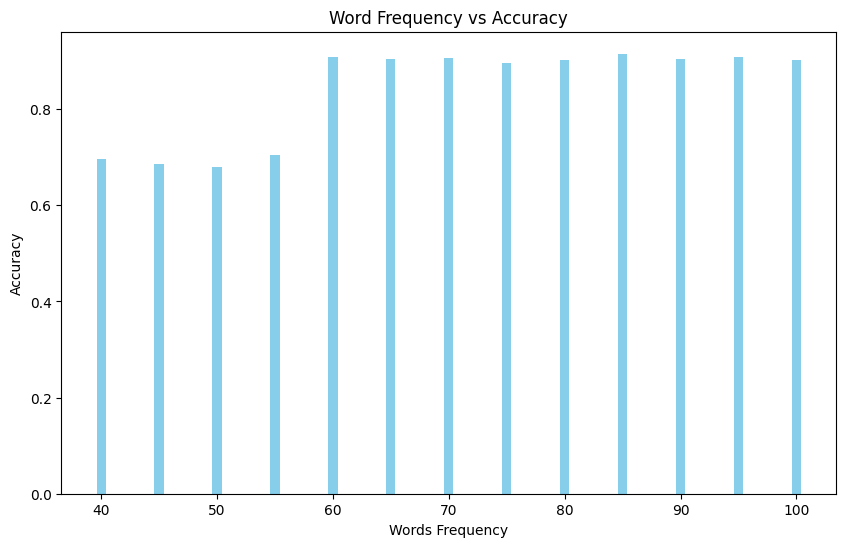

In [39]:
# Determines the accuracy score given a regularizer
def generateRegularizerAccuracyScore(reg, trainFeatures, df):
    nmfModel = NMF(n_components = 5, init='random', random_state = 123, max_iter = 1000)
    nmfModel.fit(trainFeatures[:, reg:])

    topicResults = nmfModel.transform(trainFeatures[:, reg:])
    topicResults = topicResults.argmax(axis = 1)
    topicResults = pd.Series(topicResults)

    results = [accuracy_score(df['CategoryId'], topicResults.map(transformer))
               for transformer in generatePermutationList()]

    return max(results)

startIndex = range(0, 6001, 500)
wordFrequency = range(100, 39, -5)

accuracy = [generateRegularizerAccuracyScore(start, trainFeatures, trainDataSet) for start in startIndex]

accuracyDict = {'Words Frequency': wordFrequency, 'Accuracy': accuracy}
dataFrameAccuracy = pd.DataFrame(accuracyDict)

plt.figure(figsize=(10, 6))
plt.bar(dataFrameAccuracy['Words Frequency'], dataFrameAccuracy['Accuracy'], color='skyblue')
plt.title("Word Frequency vs Accuracy")
plt.xlabel("Words Frequency")
plt.ylabel("Accuracy")
plt.show()


## Complete Data Construction

In [40]:
# Created a TF-IDF matrix from the text column
tfidfMatrix = TfidfVectorizer(max_df = .95, min_df = 5, norm = 'l2', encoding = 'latin-1', ngram_range = (1, 2), stop_words = 'english')
finalFeatures = tfidfMatrix.fit_transform(finalDataSet['Text'])

nmfModel = NMF(n_components = 5, init = 'random', random_state = 123)
nmfModel.fit(finalFeatures)

print(f"Model Information: {nmfModel}\n")
for index, topic in enumerate(nmfModel.components_):
    print(f"Top words for topic: {index}")
    print(f"Array of words: {[tfidfMatrix.get_feature_names_out()[i] for i in topic.argsort()[-15:]]}\n")

Model Information: NMF(init='random', n_components=5, random_state=123)

Top words for topic: 0
Array of words: ['chancellor', 'prime minister', 'prime', 'minister', 'howard', 'government', 'mr brown', 'mr blair', 'said', 'party', 'brown', 'election', 'blair', 'labour', 'mr']

Top words for topic: 1
Array of words: ['year', 'aviator', 'comedy', 'star', 'director', 'won', 'actress', 'films', 'oscar', 'festival', 'actor', 'award', 'awards', 'best', 'film']

Top words for topic: 2
Array of words: ['coach', 'injury', 'club', 'rugby', 'match', 'players', 'play', 'team', 'ireland', 'said', 'cup', 'wales', 'win', 'game', 'england']

Top words for topic: 3
Array of words: ['dollar', 'shares', 'company', 'china', 'prices', '2004', 'market', 'economic', 'oil', 'bank', 'sales', 'year', 'economy', 'said', 'growth']

Top words for topic: 4
Array of words: ['video', 'microsoft', 'tv', 'phones', 'software', 'net', 'broadband', 'users', 'digital', 'phone', 'technology', 'said', 'music', 'people', 'mob

In [41]:
transformers = generatePermutationList()

# Transform topics and find the best transformer
topicResults = nmfModel.transform(finalFeatures)
bestTransformerIndex = np.argmax([accuracy_score(finalDataSet['CategoryId'], pd.Series(topicResults.argmax(axis = 1)).map(transformer)) for transformer in transformers])
bestTransformer = transformers[bestTransformerIndex]

# Use the best transformer to map topic results
mappedLabels = pd.Series(topicResults.argmax(axis = 1)).map(bestTransformer)

# Compute accuracy once
result = accuracy_score(finalDataSet['CategoryId'], mappedLabels)

print("Accuracy score is:", result)

Accuracy score is: 0.6728089887640449


[Text(0, 0.5, 'business'),
 Text(0, 1.5, 'entertainment'),
 Text(0, 2.5, 'politics'),
 Text(0, 3.5, 'sport'),
 Text(0, 4.5, 'tech')]

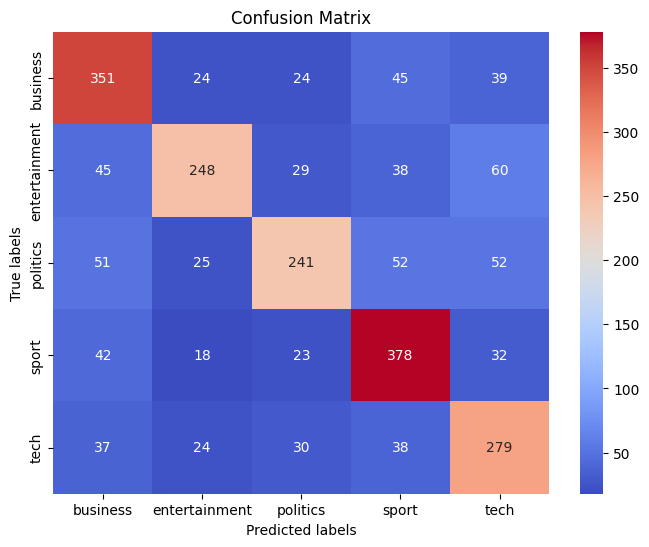

In [42]:
confusionMatrix = confusion_matrix(finalDataSet['CategoryId'], mappedLabels)

fig, subPlot = plt.subplots(figsize = (8, 6))
sns.heatmap(confusionMatrix, annot = True, fmt = 'g', ax = subPlot, cmap = 'coolwarm')

subPlot.set_xlabel('Predicted labels')
subPlot.set_ylabel('True labels')
subPlot.set_title('Confusion Matrix')
subPlot.xaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech' ])
subPlot.yaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech' ])

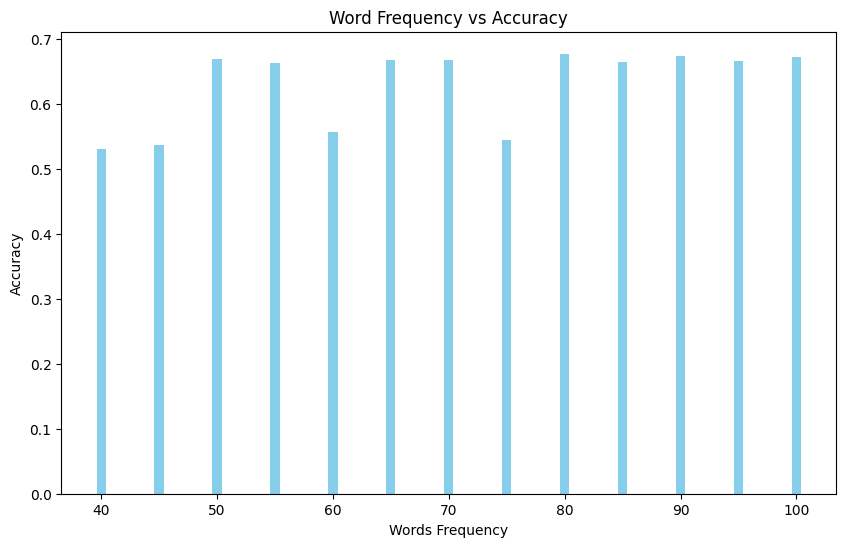

In [43]:
startIndex = range(0, 6001, 500)
wordFrequency = range(100, 39, -5)
accuracy = []
for start in startIndex:
    accuracy.append( generateRegularizerAccuracyScore(start, finalFeatures, finalDataSet) )
    
accuracyDict = {'Word Frequency': wordFrequency, 'Accuracy': accuracy}
dataFrameAccuracy = pd.DataFrame(accuracyDict)

plt.figure(figsize=(10, 6))
plt.bar(dataFrameAccuracy['Word Frequency'], dataFrameAccuracy['Accuracy'], color = 'skyblue')
plt.title("Word Frequency vs Accuracy")
plt.xlabel("Words Frequency")
plt.ylabel("Accuracy")
plt.show()

## Summary
- After using the Non-Negative Matrix Factorization model, you can clearly see from the graphs that the NFM model performs a lot better training dataset than on the final dataset.
- The train dataset performed better with about a 90% accuracy rating whereas the final data set above came in at about a 65% accuracy.
- Regularization aided in improving accuracy slightly amongst both dataset but again more so in the training dataset.

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Unsupervised vs Supervised Learning
- For supervised models, I will be using random forest and logistic regression models to evaluate accruacy from a supervised machine learning standpoint.
- I will then use those and compare them to the accuracy that I retrieved in my NFM unsupervised model using the training and final datasets.
</div>

## Train Dataset Accuracy

In [44]:
logisticRegressionModel = LogisticRegression(random_state=0).fit(trainFeatures, trainDataSet['CategoryId'])
crossValueScore = cross_val_score(logisticRegressionModel, trainFeatures, trainDataSet['CategoryId'], cv=5)
print("Best Accuracy for Logistic Regression: ", np.mean(crossValueScore))

# Random Search Param Grid
param_grid = {
    'max_depth': [8, 16],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [4, 8, 10],
    'n_estimators': [64, 128, 256]
}


randomForestModel = RandomForestClassifier()
gridSearchCv = GridSearchCV(estimator = randomForestModel, param_grid = param_grid, cv = 3, n_jobs = -1, refit = True,)
gridSearchCv.fit(trainFeatures, trainDataSet['CategoryId'])

print("Best Accuracy for Random Forest: ", gridSearchCv.cv_results_['mean_test_score'][gridSearchCv.best_index_])

Best Accuracy for Logistic Regression:  0.970469798657718
Best Accuracy for Random Forest:  0.9463176910927933


## Complete Dataset Accuracy

In [45]:
logisticRegressionModel = LogisticRegression(random_state=0).fit(trainFeatures, trainDataSet['CategoryId'])
crossValueScore = cross_val_score(logisticRegressionModel, finalFeatures, finalDataSet['CategoryId'], cv=5)
print("Best Accuracy for Logistic Regression: ", np.mean(crossValueScore))

# Random Search Param Grid
param_grid = {
  'max_depth': [8, 16],
  'min_samples_leaf': [3, 5],
  'min_samples_split': [4, 8, 10],
  'n_estimators': [64, 128, 256]
}

randomForestModel = RandomForestClassifier()
gridSearchCv = GridSearchCV(estimator = randomForestModel, param_grid = param_grid, cv = 3, n_jobs = -1, refit = True,)
gridSearchCv.fit(finalFeatures, finalDataSet['CategoryId'])

print("Best Accuracy for Random Forest: ", gridSearchCv.cv_results_['mean_test_score'][gridSearchCv.best_index_]) 

Best Accuracy for Logistic Regression:  0.7047191011235954
Best Accuracy for Random Forest:  0.690003310162198


In [46]:
comparisonDataFrame = pd.DataFrame({'NMF': [0.9034, 0.6728], 'Logistic Regression': [ 0.9705, 0.7047], 'Random Forest': [0.9456, 0.6891] }, index = ["Training Dataset", "Final Dataset"])
comparisonDataFrame

,NMF,Logistic Regression,Random Forest
Training Dataset,0.9034,0.9705,0.9456
Final Dataset,0.6728,0.7047,0.6891


## Results
- The supervised models (Logistic Regression and Random Forest) performed somewhat better than the unsupervised model.
- Overall, the Logistic Regression model performed the best at 0.9705 on the training dataset and at 0.7047 on the final data set in degree of accuracy.
- Since the Logistic Regression Model did better than the RF model, it may suggest that the random forest model had problems with overfitting data.
- All in all, you cant go wrong in using the supervised or unsupervised machine learning models since the differences in accuracies were within a tenth of a decimal point on each dataset.